# Random Forest Model Training + Feature Importance

This notebook implements the training and evaluation of a Random Forest machine learning module using a dataset publically available in a [GitHub repository](https://github.com/CPHSLab/Stress-Detection-in-Nurses/blob/main/combined_lagEDA.csv).

The models are trained in the following ways:

1. Using 70% of the data for the training and 30% for testing.
    1. Using all the features of the dataset
    2. Using only the 10 most importante features of the dataset (most influential in the final output of the model)
2. Using 90% of the data for the training and 10% for testing.
    1. Using all the features of the dataset
    2. Using only the 10 most importante features of the dataset, gathered on step 1
3. Using 50% of the data for the training and 50% for testing.
    1. Using all the features of the dataset
    2. Using only the 10 most importante features of the dataset, gathered on step 1
4. Using 30% of the data for the training and 70% for testing.
    1. Using all the features of the dataset
    2. Using only the 10 most importante features of the dataset, gathered on step 1
5. Using 10% of the data for the training and 90% for testing.
    1. Using all the features of the dataset
    2. Using only the 10 most importante features of the dataset, gathered on step 1

The metrics used for evaluating the models are:
- AUC = area below the ROC curve
- Accuracy = proportion of examples classified correctly
- F1 Score = harmonic average of recall and precision of the module
- recall = proportion of true positives considering all positives of the dataset

In all cases, the closest the metric is to 1, the better the model did in the evaluation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import shap

import time

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)

import random
import ruptures as rpt

### Turning csv file into DataFrame object

In [2]:
df_lag = pd.read_csv("./combinedlagEDA.csv")
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.3, random_state=30)

### Function to train model:

In [3]:
# dataframe_lag (pd.DataFrame) - dataset in DataFrame format
# test_percentage (decimal) - percentage of data used for testing the module
# return_model (boolean) - should the Random Forest model be returned
# features_used (list of strings) - feature labels that should be used. If empty, all features are used
def train_model(dataframe_lag, test_percentage, return_model=False, features_used=[]):
    # TODO: add support for features_used
    if len(features_used) != 0:
        data = pd.concat([df_lag[feature] for feature in features_used], axis=1)
        train_set = data.iloc[:,0:len(features_used)-1]
        labels = data.iloc[:,len(features_used)-1:len(features_used)]
    else: 
        train_set = dataframe_lag.iloc[:,0:48]
        labels = dataframe_lag.iloc[:,48:49]
        
    # split data into train and test
    train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=test_percentage)
    
    # create and train Random Forest classifier
    start_time = time.time()
    random_forest = RandomForestClassifier(n_estimators=100,max_depth=15)
    random_forest.fit(train, train_labels.values.ravel())
    y_pred_rf = random_forest.predict(test)
    execution_time = time.time() - start_time
    
    # calculate metrics for evaluation 
    f1score   = f1_score        (test_labels, y_pred_rf, average = 'macro')
    recall    = recall_score    (test_labels, y_pred_rf, average = 'macro')
    accuracy  = accuracy_score  (test_labels, y_pred_rf)
    AUC       = roc_auc_score   (test_labels.values.ravel(), random_forest.predict_proba(test), multi_class='ovr')
    
    if return_model:
        return f1score, recall, accuracy, AUC, execution_time, random_forest
    else:
        return f1score, recall, accuracy, AUC, execution_time

1.A Training with 70% of data, testing with 30% of data

In [4]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.3, return_model=True)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9938577235052447
acc = 0.9477771826459561
f1 = 0.9350860962231639
recall = 0.9259127448603636
time of training = 2.9000024795532227 seconds


Get top 10 features from model

In [5]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = df_lag.columns
top10 = [features[i] for i in indices[-10:]]
print('The top 10 features (10th to 1st) are:', top10)
top10.append('Stress') # last item should be the label (expected answer)

The top 10 features (10th to 1st) are: ['EDAR_Mean-2', 'EDAR_Mean-1', 'EDAR_Min', 'EDAR_Max', 'HRR_Min', 'TEMPR_Max', 'TEMPR_Min', 'HRR_Mean', 'HRR_Max', 'TEMPR_Mean']


### Feature importance graph

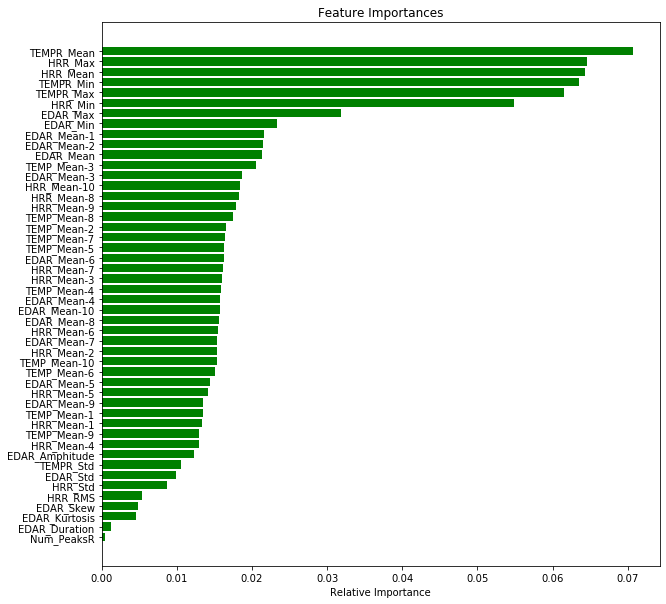

In [6]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = df_lag.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

1.B Training with 70% of data, testing with 30% of data using top 10 features

In [7]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.3, return_model=True, features_used=top10)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9859526020236703
acc = 0.9156400642742367
f1 = 0.9031521143507423
recall = 0.896040193733843
time of training = 1.5229039192199707 seconds


2.A Training with 90% of data, testing with 10% of data

In [8]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.1, return_model=True)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.99541086373658
acc = 0.9606425702811245
f1 = 0.9512193886710185
recall = 0.9440556477858676
time of training = 3.491544485092163 seconds


2.B Training with 90% of data, testing with 10% of data using top 10 features

In [9]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.1, return_model=True, features_used=top10)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.990334356183916
acc = 0.934136546184739
f1 = 0.9221955184984871
recall = 0.9143680822674342
time of training = 1.7055330276489258 seconds


3.A Training with 50% of data, testing with 50% of data

In [10]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.5, return_model=True)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9860623222003143
acc = 0.9177245701430178
f1 = 0.9002087076780283
recall = 0.8884830053887431
time of training = 1.9462223052978516 seconds


3.B Training with 50% of data, testing with 50% of data using top 10 features

In [11]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.5, return_model=True, features_used=top10)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9790944441416868
acc = 0.901655150249076
f1 = 0.8809694044608808
recall = 0.8706952319722032
time of training = 1.039067029953003 seconds


4.A Training with 30% of data, testing with 70% of data

In [12]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.7, return_model=True)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.969013460810856
acc = 0.866505968778696
f1 = 0.82924751027003
recall = 0.8117338591707545
time of training = 1.1902649402618408 seconds


4.B Training with 30% of data, testing wih 70% of data using top 10 features

In [13]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.7, return_model=True, features_used=top10)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9643358488815598
acc = 0.8736225895316805
f1 = 0.8476962946814061
recall = 0.8350245359057423
time of training = 0.683086633682251 seconds


5.A Training with 10% of data, testing with 90% of data

In [14]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.9, return_model=True)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9059874401463678
acc = 0.7779662530131238
f1 = 0.7227560203410585
recall = 0.7092442588498914
time of training = 0.5451159477233887 seconds


5.B Training with 10% of data, testing wih 90% of data using top 10 features

In [15]:
f1, recall, accuracy, AUC, execution_time, model = train_model(df_lag, 0.9, return_model=True, features_used=top10)
print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1)
print('recall =', recall) 
print('time of training =', execution_time, 'seconds')

auc = 0.9102830305622235
acc = 0.7942148022497991
f1 = 0.7513498109847664
recall = 0.7442097265117787
time of training = 0.3550839424133301 seconds
